In [1]:
import string
import numpy as np

import os
from pickle import dump, load
from numpy import argmax

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences

from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Image, display
from shutil import copyfile

### Functions for extracting features and predicting captions for the querry image

In [2]:
def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature


In [5]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text




 two dogs are running through the grass 




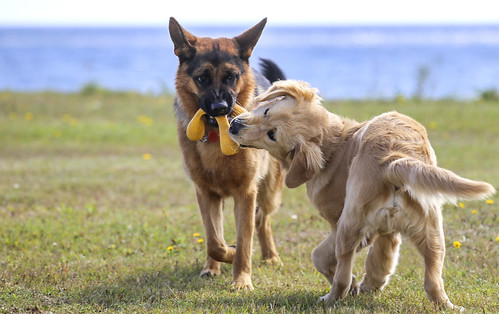

In [6]:
# load the tokenizer
tokenizer = load(open('../Caption_Generator/tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34

# load trained model..
model = load_model('../Caption_Generator/model.h5')

# load and prepare the photograph
img = "C:/xampp/htdocs/uploads/photo.jpg"
photo = extract_features(img)
# generate description
predicted_description = generate_desc(model, tokenizer, photo, max_length)
print_description = ' '.join(predicted_description.split(' ')[1:-1])
print("\n\n",print_description,"\n\n")

desc_file = open('C:/xampp/htdocs/uploads/description.txt',"w")
desc_file.write(print_description)
desc_file.close()

z = Image(filename=img)
display(z)


# Storing the description in xampp file..
desc_file = open('C:/xampp/htdocs/uploads/description.txt',"w")
desc_file.write(print_description)
desc_file.close()

In [7]:
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Function for loading a pre-defined list of photo identifiers
def load_photo_identifiers(filename):
    file = load_file(filename)
    photos = list()
    for line in file.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        photos.append(identifier)
    return set(photos)

def load_clean_descriptions(filename, photos):
    file = load_file(filename)
    descriptions = dict()
    for line in file.split('\n'):
        words = line.split()
        image_id, image_description = words[0], words[1:]
        if image_id in photos:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

# function to load the photo features created using the VGG16 model
def load_photo_features(filename, photos):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in photos}
    
    return features

In [8]:
dataset_root_dir = "../Caption_Generator/"

input_file = open('C:/xampp/htdocs/uploads/description.txt', 'r')
predicted_description = input_file.readline()

table = str.maketrans('','',string.punctuation)
desc = predicted_description.split()
desc = [word.lower() for word in desc]
desc = [word.translate(table) for word in desc]
desc = [word for word in desc if len(word)>1]
desc = [word for word in desc if word.isalpha()]
predicted_description =  ' '.join(desc)


### match images similar to querry image.. using BLEU score >0.4

6
{'3333921867_6cc7d7c73d', '2890113532_ab2003d74e', '2148916767_644ea6a7fa', '2933912528_52b05f84a1', '2589241160_3832440850', '3462454965_a481809cea'}


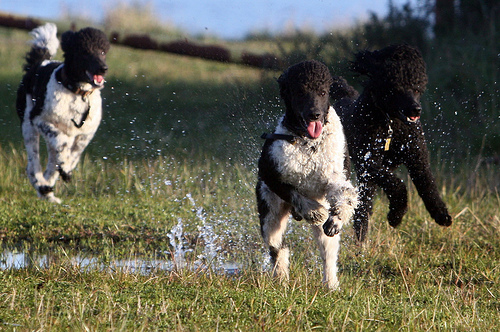

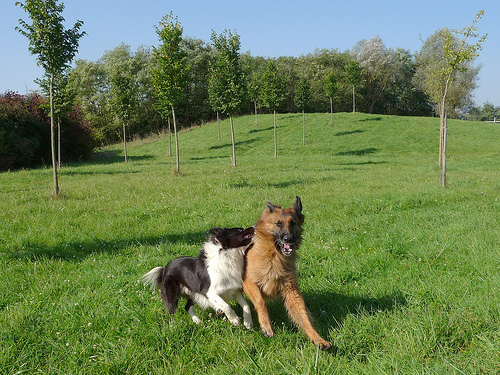

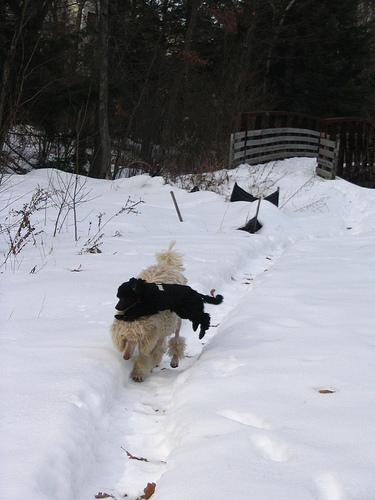

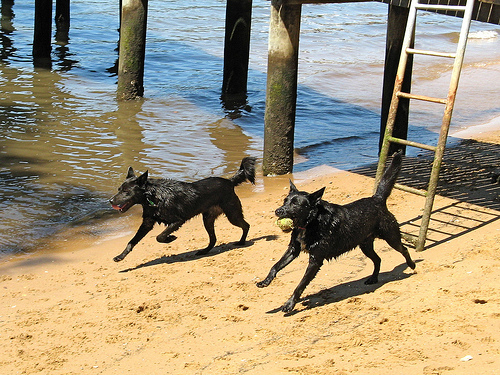

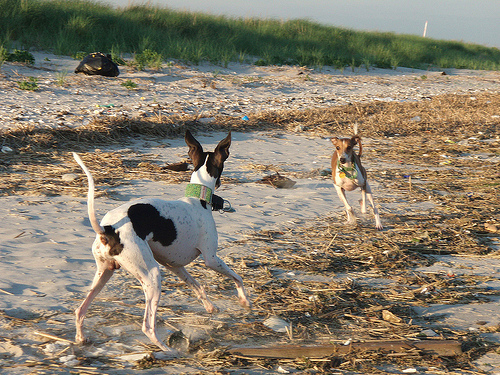

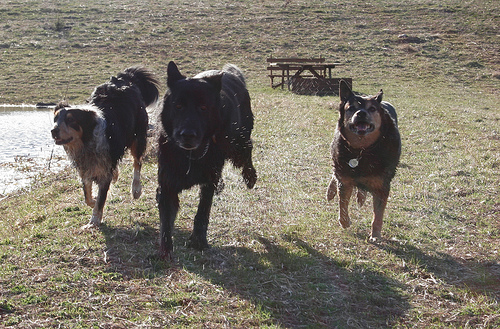

In [9]:
testFile = dataset_root_dir + 'Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
testImagesLabel = load_photo_identifiers(testFile)
test_descriptions = load_clean_descriptions(dataset_root_dir+'Flickr_Data' + '/descriptions.txt', testImagesLabel)

matchedFiles = set()

for img in testImagesLabel:
    actual, predicted = list(), list()
    yhat = predicted_description.split()
    predicted.append(yhat)
    references = [d.split() for d in test_descriptions[img]]
    actual.append(references) 
    bleu_score_1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
    bleu_score_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_score_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.34, 0))
    bleu_score_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_score = ( 4*bleu_score_4 + 3*bleu_score_3 + 2*bleu_score_2 + bleu_score_1 )/10
    #print(bleu_score)
    if bleu_score > 0.4:
        matchedFiles.add(img)
        continue


print(len(matchedFiles))
print(matchedFiles)

img_root = '../Caption_Generator/Flickr_Data/Images/'
for i in matchedFiles:
    z = Image(filename=img_root+i+".jpg")
    display(z)


#### Create a folder matched-images and stores these image in it
#### Also store those images description in 'matches_image.txt' file in xampp

In [10]:
folder = 'C:\\xampp\\htdocs\\uploads\\matched-images'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [11]:
def load_description_mapping(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line)<2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

In [12]:
matched_img_file = open('C:\\xampp\\htdocs\\uploads\\matched_images.txt',"w")
img_root = '../Caption_Generator/Flickr_Data/Images/'


desc_text = load_file(dataset_root_dir + 'Flickr_Data/Flickr_TextData/Flickr8k.token.txt')
descriptions = load_description_mapping(desc_text)

i=0
for img in matchedFiles:
    img_path = img_root + img + '.jpg'
    i += 1
    matched_img_file.write(descriptions[img][0]+ '\n')
    copyfile(img_path, folder + '/' + format(i,'03d') + '.jpg')
    
matched_img_file.close()